# Bikeshare rides (Summer 2018)
This notebook analyzes bikeshare data for NYC citibikes. 

Here we get some of the bike data (Jun - Aug of 2018) as a sample set and perform some basic exploratory analysis and plot-making

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

import os
os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap


In [7]:
#Grab the data for summer 2018
summer_df_list = []

for el in ['06','07','08']:
    summer_df_list.append(pd.read_csv('../data/NYC/2018/2018{}-citibike-tripdata/2018{}-citibike-tripdata.csv'.format(el,el)))

summer_df_list[0].head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1


In [8]:
#Concat them all together into one dataframe
summer_df = pd.concat(summer_df_list,ignore_index=True)
summer_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72.0,W 52 St & 11 Ave,40.767272,-73.993929,173.0,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72.0,W 52 St & 11 Ave,40.767272,-73.993929,477.0,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72.0,W 52 St & 11 Ave,40.767272,-73.993929,457.0,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72.0,W 52 St & 11 Ave,40.767272,-73.993929,379.0,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72.0,W 52 St & 11 Ave,40.767272,-73.993929,459.0,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1


In [9]:
# Comments: 
# The max value for tripduration, there are several trips that are unreasonably long (10^6 seconds is more than 10 days)
# The max latitudes are over 45 degrees! That's not even in New York!
# The min birthyear is 1885! We'll leave these since we can filter out the anomalous ages later if we want to look at age data
summer_df[['tripduration','birth year','start station latitude','start station longitude','end station latitude','end station longitude']].describe().round(2)

,tripduration,birth year,start station latitude,start station longitude,end station latitude,end station longitude
count,5843905.0,5843905.00,5843905.00,5843905.00,5843905.00,5843905.00
mean,1099.1,1979.25,40.74,-73.98,40.74,-73.98
std,18421.5,11.74,0.03,0.02,0.03,0.02
min,61.0,1885.00,40.65,-74.03,40.65,-74.08
25%,380.0,1969.00,40.72,-74.00,40.72,-74.00
50%,652.0,1982.00,40.74,-73.99,40.74,-73.99
75%,1149.0,1989.00,40.76,-73.97,40.76,-73.97
max,7571338.0,2002.00,45.51,-73.57,45.51,-73.57


In [10]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 26 
num_WD = 31+31+30- num_WE#Note I'm not subtracting holidays here, maybe later...

The next few cells use the functions in `bike_share_functions.py` to clean the bike data and assemble an independent station dataframe. Finally, pickled versions of the dataframes are saved to disk.

In [11]:
import sys
sys.path.append('../')

from bike_share_functions import bike_clean_df, get_stations_info, get_trip_info

In [12]:
#Cleans data, see output
subs_df = bike_clean_df(summer_df)
print('Total trips remaining: {}'.format(len(subs_df)))

Dropped 1388 NaN entries
Dropped an additional 816272 non-subscriber entries
Dropped an additional 4998 entries with trips longer than 2 hours
Changed type of start station id and end station id to integer
Changed type of starttime and stoptime to datetime
Dropped an additional 12 trips with start/end stations outside NYC
Total trips remaining: 5021235


In [13]:
#Creates an independent dataframe with station names and locations
stations_info_df = get_stations_info(subs_df)
print('total stations: {}'.format(len(stations_info_df))) # get the number of stations
stations_info_df.head()

total stations: 802


,lat,lon,station name
72,40.767272,-73.993929,W 52 St & 11 Ave
79,40.719116,-74.006667,Franklin St & W Broadway
82,40.711174,-74.000165,St James Pl & Pearl St
83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl
119,40.696089,-73.978034,Park Ave & St Edwards St


In [14]:
#get_trip_info removes some redundant station info from subs_df and also creates some new columns
subs_trips_df = get_trip_info(subs_df)

subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
0,569,2018-06-01 01:57:20.514,2018-06-01 02:06:50.088,72,173,21481,1999,1,4,4,1,2,19,Late Night,"(72, 173)"
1,480,2018-06-01 02:02:42.398,2018-06-01 02:10:43.354,72,477,19123,1988,1,4,4,2,2,30,Late Night,"(72, 477)"
2,692,2018-06-01 02:04:23.624,2018-06-01 02:15:55.747,72,457,26983,1986,1,4,4,2,2,32,Late Night,"(72, 457)"
3,664,2018-06-01 03:00:55.461,2018-06-01 03:11:59.906,72,379,26742,1973,1,4,4,3,3,45,Late Night,"(72, 379)"
4,818,2018-06-01 06:04:54.427,2018-06-01 06:18:32.617,72,459,26386,1984,1,4,4,6,6,34,Commuter,"(72, 459)"


In [21]:
summer_df.to_pickle('../data/pickledDFs/NYC_Summer_2018.pkl')

In [8]:
#Export the results as pickled dateframes for use in other analyses 
subs_df.to_pickle('../data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df.to_pickle('../data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df.to_pickle('../data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')

Now, separate out weekday vs weekend trips and check some details 

In [15]:
#Separate out the weekday and weekend trips
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [16]:
summer_df[['tripduration','birth year']].describe().round(2)

,tripduration,birth year
count,5842517.00,5842517.00
mean,1098.70,1979.25
std,18421.45,11.74
min,61.00,1885.00
25%,380.00,1969.00
50%,652.00,1982.00
75%,1149.00,1989.00
max,7571338.00,2002.00


In [17]:
weekday_subs_trips_df[['tripduration','age']].describe().round(2)

,tripduration,age
count,3935189.00,3935189.00
mean,751.75,38.34
std,571.76,11.85
min,61.00,16.00
25%,353.00,29.00
50%,582.00,36.00
75%,980.00,47.00
max,7199.00,133.00


In [22]:
weekend_subs_trips_df[['tripduration','age']].describe().round(2)

,tripduration,age
count,1086046.00,1086046.00
mean,805.45,37.26
std,644.05,11.75
min,61.00,16.00
25%,357.00,28.00
50%,605.00,34.00
75%,1064.00,45.00
max,7197.00,133.00


In [23]:
print('total weekday trips: {}'.format(len(weekday_subs_trips_df)))
print('total weekend trips: {}'.format(len(weekend_subs_trips_df)))
print('Sum: {}'.format(len(weekend_subs_trips_df)+len(weekday_subs_trips_df)))

total weekday trips: 3935189
total weekend trips: 1086046
Sum: 5021235


The following are just simple plots of various aspects of the data.

The first two are total trip counts per hour for weekday and weekend.

Text(0, 0.5, 'Number of Trips')

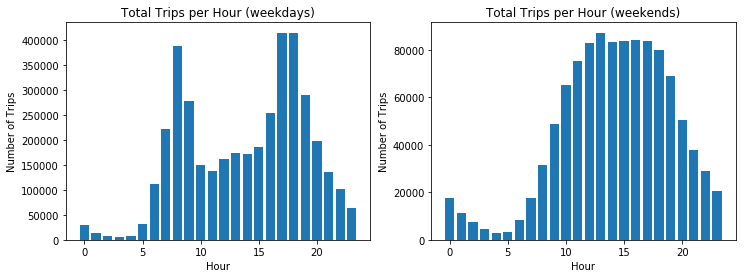

In [49]:
#Total trips (= num pickups) by hour 
fig, ax= plt.subplots(1,2,figsize = (12,4)) 


WD_total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax[0].bar(WD_total_rides_by_hour.index,WD_total_rides_by_hour)
ax[0].set_title('Total Trips per Hour (weekdays)')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of Trips')

WE_total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax[1].bar(WE_total_rides_by_hour.index,WE_total_rides_by_hour)
ax[1].set_title('Total Trips per Hour (weekends)')
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of Trips')

Now we plot the same for a single station, choosing the station with the most total trips

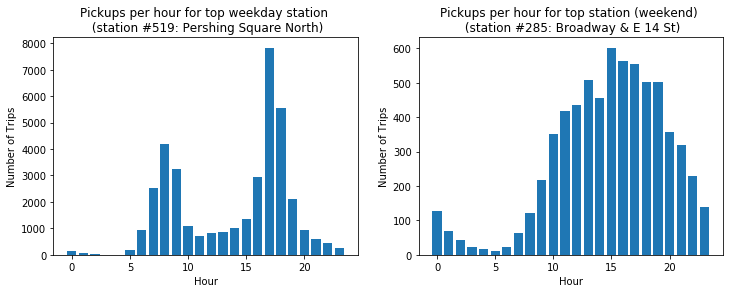

In [51]:
fig, ax= plt.subplots(1,2,figsize = (12,4)) 


WD_total_rides_by_hr_st = weekday_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
WD_total_rides_by_hr_st = WD_total_rides_by_hr_st.rename('total_trips') 

#max_pu_st = total_rides_by_hr_st.idxmax()[1]
WD_max_pu_st = weekday_subs_trips_df.groupby(['start station id'])['tripduration'].count().idxmax()

WD_top_pu_station = WD_total_rides_by_hr_st.loc[:,WD_max_pu_st]

WE_total_rides_by_hr_st = weekend_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
WE_total_rides_by_hr_st = WE_total_rides_by_hr_st.rename('total_trips') 

#max_pu_st = total_rides_by_hr_st.idxmax()[1]
WE_max_pu_st = weekend_subs_trips_df.groupby(['start station id'])['tripduration'].count().idxmax()

WE_top_pu_station = WE_total_rides_by_hr_st.loc[:,WE_max_pu_st]


ax[0].bar(WD_top_pu_station.index,WD_top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) station (weekday)')
ax[0].set_title('Pickups per hour for top weekday station \n (station #{}: {})'.format(WD_max_pu_st,stations_info_df.loc[WD_max_pu_st]['station name']))
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of Trips')

ax[1].bar(WE_top_pu_station.index,WE_top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) weekend station')
ax[1].set_title('Pickups per hour for top station (weekend) \n (station #{}: {})'.format(WE_max_pu_st,stations_info_df.loc[WE_max_pu_st]['station name']))
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of Trips');


Plots of average trip duration by hour for weekdays and weekends

Text(0.5, 1.0, 'Average trip duration by hour (weekend)')

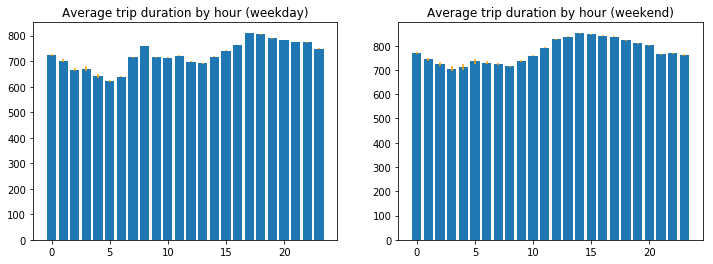

In [53]:
fig, ax= plt.subplots(1,2,figsize = (12,4)) 


WD_avg_duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()
WD_total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
WD_yerror = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(WD_total_rides_by_hour)**(1/2)

ax[0].bar(WD_avg_duration_by_hour.index,WD_avg_duration_by_hour, yerr=WD_yerror,ecolor = 'orange')
ax[0].set_title('Average trip duration by hour (weekday)')

WE_avg_duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()
WE_total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
WE_yerror = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(WE_total_rides_by_hour)**(1/2)

ax[1].bar(WE_avg_duration_by_hour.index,WE_avg_duration_by_hour, yerr=WE_yerror,ecolor = 'orange')
ax[1].set_title('Average trip duration by hour (weekend)')

Plots of average age by hour

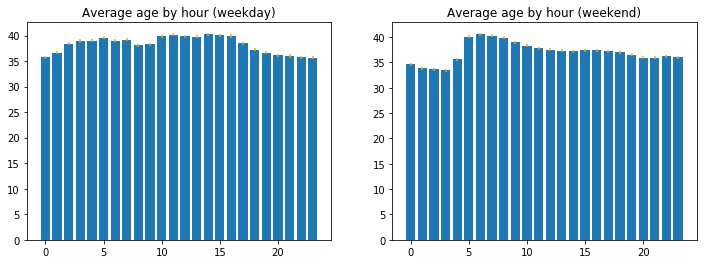

In [55]:
fig, ax= plt.subplots(1,2,figsize = (12,4)) 

WD_avg_age_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].mean()

WD_total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].count()
WD_yerror = weekday_subs_trips_df.groupby('pickup_hour')['age'].std()/WD_avg_age_by_hour #Relative standard deviation instead of std dev of mean

ax[0].bar(WD_avg_age_by_hour.index,WD_avg_age_by_hour,yerr=WD_yerror, ecolor='orange')
ax[0].set_title('Average age by hour (weekday)')

WE_avg_age_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].mean()

WE_total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].count()
WE_yerror = weekend_subs_trips_df.groupby('pickup_hour')['age'].std()/WE_avg_age_by_hour #Relative standard deviation instead of std dev of mean

ax[1].bar(WE_avg_age_by_hour.index,WE_avg_age_by_hour,yerr=WE_yerror, ecolor='orange')
ax[1].set_title('Average age by hour (weekend)');

Trip duration histograms

Text(0.5, 1.0, 'Trip duration histogram')

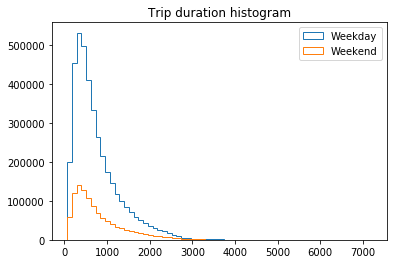

In [56]:
fig = plt.figure()
ax = fig.gca()

weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
ax.grid(False)
ax.legend(['Weekday', 'Weekend'])
ax.set_title('Trip duration histogram')

Text(0.5, 1.0, 'Trip duration histogram')

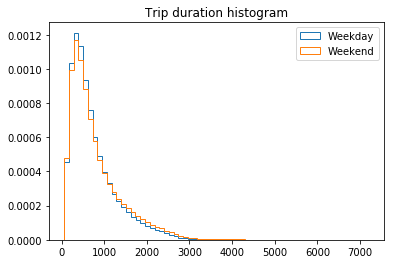

In [57]:
fig = plt.figure()
ax = fig.gca()

weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step',density=True)
weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step',density=True)
ax.grid(False)
ax.legend(['Weekday', 'Weekend'])
ax.set_title('Trip duration histogram')

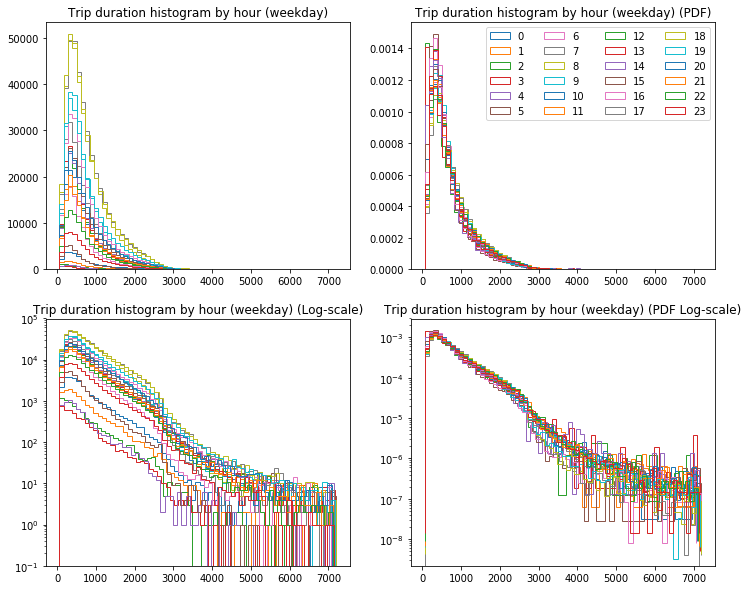

In [25]:
fig, ax = plt.subplots(2,2,figsize=(12,10))



duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0,0])
duration_by_hour.hist(bins=64,histtype ='step')

plt.sca(ax[0,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True)

plt.sca(ax[1,0])
duration_by_hour.hist(bins=64,histtype ='step',log=True)

plt.sca(ax[1,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True,log=True)

ax[0,0].set_title('Trip duration histogram by hour (weekday)')
ax[0,0].grid(False)


ax[0,1].set_title('Trip duration histogram by hour (weekday) (PDF)')
ax[0,1].grid(False)

ax[1,0].set_title('Trip duration histogram by hour (weekday) (Log-scale)')
ax[1,0].grid(False)


ax[1,1].set_title('Trip duration histogram by hour (weekday) (PDF Log-scale)')
ax[1,1].grid(False)

ax[0,1].legend(labels = list(range(24)),ncol=4)

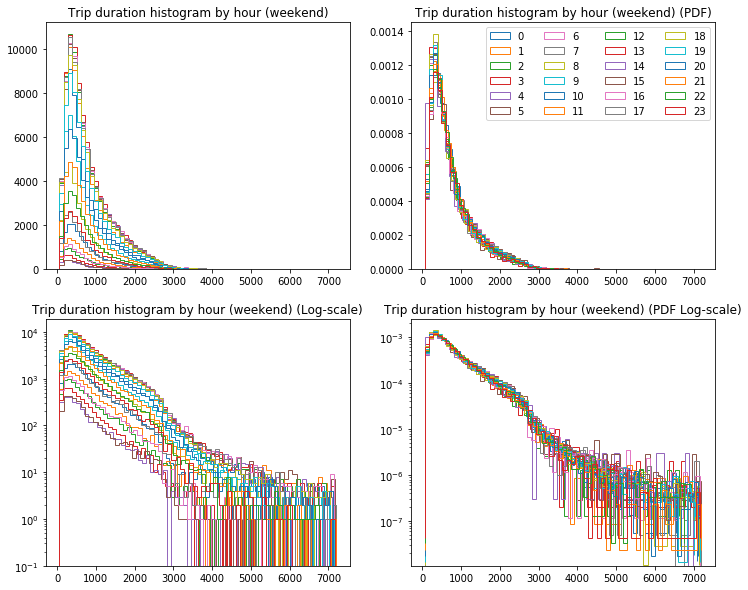

In [79]:
fig, ax = plt.subplots(2,2,figsize=(12,10))



duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0,0])
duration_by_hour.hist(bins=64,histtype ='step')

plt.sca(ax[0,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True)

plt.sca(ax[1,0])
duration_by_hour.hist(bins=64,histtype ='step',log=True)

plt.sca(ax[1,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True,log=True)

ax[0,0].set_title('Trip duration histogram by hour (weekend)')
ax[0,0].grid(False)


ax[0,1].set_title('Trip duration histogram by hour (weekend) (PDF)')
ax[0,1].grid(False)

ax[1,0].set_title('Trip duration histogram by hour (weekend) (Log-scale)')
ax[1,0].grid(False)


ax[1,1].set_title('Trip duration histogram by hour (weekend) (PDF Log-scale)')
ax[1,1].grid(False)

ax[0,1].legend(labels = list(range(24)),ncol=4)

Text(0.5, 1.0, 'Age histogram (weekday)')

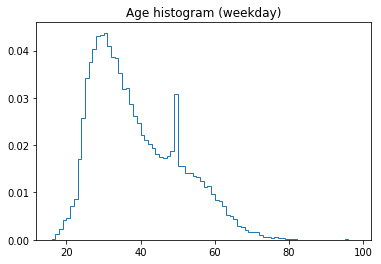

In [19]:
fig = plt.figure()
ax = fig.gca()


ages_series  = weekday_subs_trips_df[weekday_subs_trips_df['age'] < 100]['age']
#duration_by_hour = short_weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

ages_series.hist(bins=list([n for n in range(ages_series.min(),ages_series.max())]),histtype='step',density=True)

#ax.hist(duration_by_hour)

ax.grid(False)
#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Age histogram (weekday)')
#ax.legend(labels = list(range(24)),ncol=4)

In [38]:
#For some reason there are alot of users that are near 50, it turns out 49 is the number with the sharp peak above
ages_series.groupby(by=ages_series).count().nlargest(15)

age
30    172141
29    169863
28    169488
31    161501
27    158441
32    152336
33    151524
26    147560
34    139066
25    134459
36    125817
35    125486
49    121219
37    112992
38    102774
Name: age, dtype: int64

In [39]:
# This is actually less interesting than it would appear, if we look at it in terms of birthyear.... 
# Perhaps we should take the age listings with a grain of salt...
birthyear_series= weekday_subs_trips_df[weekday_subs_trips_df['age'] < 100]['birth year']
birthyear_series.groupby(by=birthyear_series).count().nlargest(15)

birth year
1988    172141
1989    169863
1990    169488
1987    161501
1991    158441
1986    152336
1985    151524
1992    147560
1984    139066
1993    134459
1982    125817
1983    125486
1969    121219
1981    112992
1980    102774
Name: birth year, dtype: int64

Can also consider distribution for individual bike usage (total time)

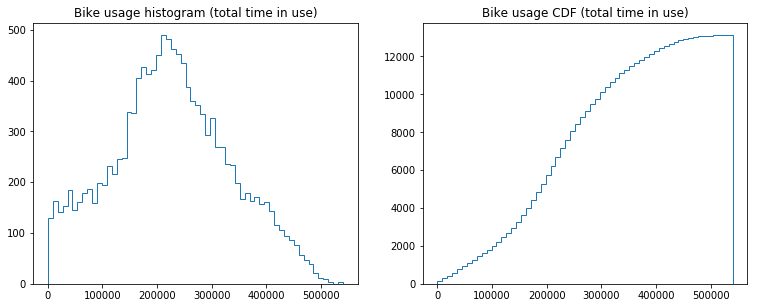

In [58]:
fig = plt.subplots(1,2,figsize=(12.8,4.8))


total_duration_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].sum()


plt.subplot(121)
total_duration_by_bikeid.hist(bins=60,histtype='step')#,density=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage histogram (total time in use)')

plt.subplot(122)
total_duration_by_bikeid.hist(bins=60,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage CDF (total time in use)')

plt.show()

Similar results for total number of trips

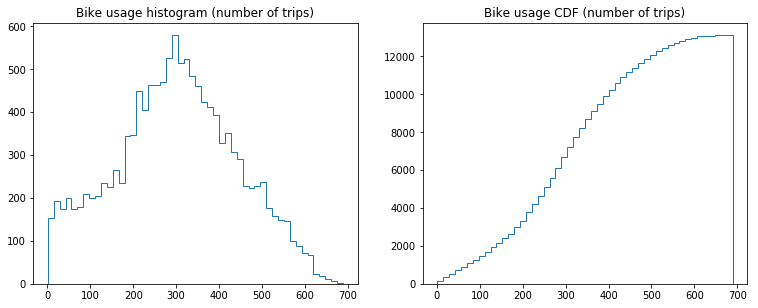

In [61]:
fig = plt.subplots(1,2,figsize=(12.8,4.8))
#ax = fig.gca()

total_trips_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].count()

plt.subplot(121)
total_trips_by_bikeid.hist(bins=50,histtype='step')
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage histogram (number of trips)')

plt.subplot(122)
total_trips_by_bikeid.hist(bins=50,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage CDF (number of trips)')

plt.show()



#ax.set_title('Bike usage histogram (total trips)')
#total_trips_by_bikeid.sort_values(ascending=False).head()

In [63]:
total_duration_by_bikeid.nlargest(5)

bikeid
30868    539979
32427    539781
33522    536451
33162    532381
31217    520628
Name: tripduration, dtype: int64

In [66]:
ave_trip_length_by_bikeid = total_duration_by_bikeid.astype(float)/total_trips_by_bikeid.astype(float)/60
#print(ave_trip_length_by_bikeid.mean())
#print(ave_trip_length_by_bikeid.median())
ave_trip_length_by_bikeid.describe().round(2)

count    13115.00
mean        12.55
std          1.68
min          1.23
25%         11.98
50%         12.49
75%         13.00
max         98.50
Name: tripduration, dtype: float64

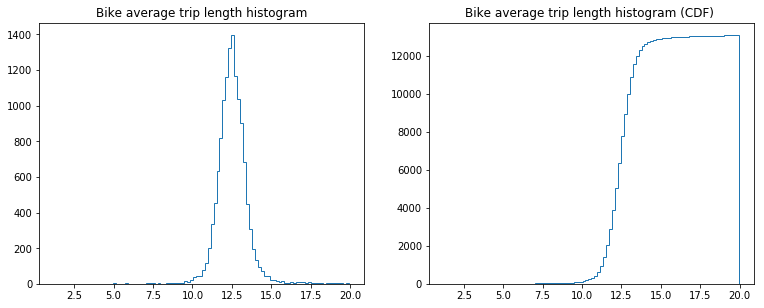

In [70]:
fig, ax = plt.subplots(1,2,figsize=(12.8,4.8))

plt.subplot(121)
ave_trip_length_by_bikeid[ave_trip_length_by_bikeid < 20].hist(bins=100,histtype='step')
plt.grid(False)
ax=plt.gca()
ax.grid(False)
#ax.set_xlim(right=30)
ax.set_title('Bike average trip length histogram');

plt.subplot(122)
ave_trip_length_by_bikeid[ave_trip_length_by_bikeid < 20].hist(bins=100,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.grid(False)
ax.set_title('Bike average trip length histogram (CDF) ');

In [71]:
print(len(ave_trip_length_by_bikeid[ave_trip_length_by_bikeid < 20]))
print(len(ave_trip_length_by_bikeid))

13083
13115


In [50]:
#Average trip time in minutes
weekday_subs_trips_df['tripduration'].astype(float).describe().loc['mean']/60

12.52923486860055

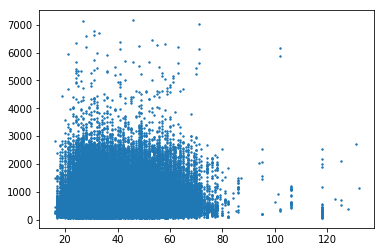

In [23]:
fig = plt.figure()

plt.scatter(weekday_subs_trips_df['age'].iloc[:100000],weekday_subs_trips_df['tripduration'].iloc[:100000],s=2)